# CNN Text Classifier

by Michael Hunziker

## Summary
The aim of this notebook is to train a CNN text classifier for our predictions.


*   Prepare Dataset
*   


</br>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-adv-nlp/blob/main/adv_nlp_assignment_mh_04_CNN_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do some imports

In [ ]:
# %%capture

# !pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

# from fhnw.nlp.utils.storage import download
# from fhnw.nlp.utils.storage import load_dataframe

# import pandas as pd
# import numpy as np

# from fhnw.nlp.utils.system import set_log_level
# from fhnw.nlp.utils.system import system_info

# set_log_level()
# print(system_info())

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

# should prevent verbose logging
set_log_level(2)

import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.1.85+
Python version: 3.10.12
CPU brand: Intel(R) Xeon(R) CPU @ 2.00GHz
CPU cores: 1
RAM: 12.67GB total and 11.28GB available
Tensorflow version: 2.17.1
GPU is available


In [3]:
# create a DEV variable to use later
DEV = True

In [7]:
%%time

!rm "./data/COVIDSenti_tokenized_02.parq"

download("https://github.com/miam-bonbon/assignment-adv-nlp/raw/refs/heads/main/data/COVIDSenti_tokenized_02.parq", "data/COVIDSenti_tokenized_02.parq")
data = load_dataframe("data/COVIDSenti_tokenized_02.parq")
data.shape

rm: cannot remove './data/COVIDSenti_tokenized_02.parq': No such file or directory
CPU times: user 207 ms, sys: 64.6 ms, total: 272 ms
Wall time: 1.65 s


(22516, 8)

In [8]:
data.head(3)

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi...","[tldr, :, sars, ,, possibly, new, coronavirus,..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...,"[#ccp, keep, saying, unknown, cause, pneumonia..."
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...,"[always, feel, weird, hoping, another, coronav..."


Import some helper functions (later we will overwrite some functions in order to provide a better understanding of the process)...

In [4]:
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.ploting import report_classification_results

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

In [25]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "token_clean_tweet_tokenize",
    "y_column_name": "label",
}

if runs_on_colab():
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name

...extract the vocabulary...

In [26]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 11
Percentil (0.98) cutoff sequence length: 18
Max sequence length: 36
Used embedding sequence length: 18


Is this right? We check our current data in excel

In [10]:
if (True):
  from google.colab import drive
  drive.mount('/content/drive')
  csv_file_path = '/content/drive/My Drive/COVIDSenti_tokenized_02.csv'

  data.to_csv(csv_file_path, index=False)  # index=False prevents writing row indices to the file

  print(f"DataFrame saved to: {csv_file_path}")

Mounted at /content/drive
DataFrame saved to: /content/drive/My Drive/COVIDSenti_tokenized_02.csv


Our tweets are indeed very short on average - let's see if it's still possible

### Keras TextVectorization layer
We use the Keras TextVectorization layer - do we have to adapt, because we already tokenized?

In [27]:
def extract_text_vectorization_and_set(params):
    """Creates the TextVectorization layer and a vocabulary iterator and puts them into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    from tensorflow.keras.layers import TextVectorization

    verbose = params.get("verbose", False)
    output_sequence_length = params.get("output_sequence_length", None)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary = params.setdefault(computed_objects_column_name, {})["vocabulary"]
    if verbose:
        print("Vocabulary length:", len(vocabulary))

    vectorize_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=output_sequence_length,
        vocabulary=list(vocabulary),
        name="text_vectorization"
    )

    params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"] = vectorize_layer.get_vocabulary()
    params.setdefault(computed_objects_column_name, {})["vectorize_layer"] = vectorize_layer

    if verbose:
        print("Vocabulary length:", vectorize_layer.vocabulary_size())

Show our vocabulary

In [28]:
# Example usage (assuming params dictionary is already defined and populated as shown in the provided code):
vocabulary = params.get("computed_objects", {}).get("vocabulary")

print(vocabulary)

{'spread', 'hiv/aids', 'album', 'bets', 'shiller', 'sms', 'kuruna', 'mayhem', 'veneto', 'tournament', 'locals', 'fits', 'adminitration', 'thicc', 'wechat', 'righ', 'majors', 'toxicn', 'coronaviruspreparation', 'stupidtrump', 'snatch', 'xenophobia', 'parasite', 'yep', 'repatr', 'fiddle', 'pre-exist', '-reuters', 'flu-based', 'national', 'elbows', 'organising', 'never', 'barbell', 'chapstick', 'doordash', 'timelines', 'bat/', 'joy', 'introduces', 'submit', 'eurosport', 'rawislaw', 'aaron', 'whoever', 'afghanistan', 'narrative', 'assuming', 'ron', 'chart', 'ultimatelove', 'gtc', 'karanadwaith', 'indagine', 'sanitary', 'precautionary', 'innovative', "'", '.pls', 'wrenching', 'people/asylum', 'backing', 'mooj', 'scientist/researcher', 'afraid', 'mediamanipulation', 'sarcastic', 'helped', 'evacuating', 'wackiness', 'canada', 'meant', 'yuenglingvirus', 'rebel', 'frontpagemag', 'match', 'populatio', 'brazen', 'bam', 'seamless', 'feelz', 'involved', "'thermonuclear", 'impala', 'illinois', 'rude

It is rather small, but for now we stick with it and cross our fingers</br>
We don't have to adapt for tokenized input

In [20]:
# params = {
#     "verbose": True,
#     "shuffle": True,
#     # modify batch_size in case you experience memory issues
#     "batch_size": 128,
#     "X_column_name": "cleaned_tweet",
#     "y_column_name": "label",
# }

# # params["X_column_name"] = "cleaned_tweet"

In [29]:
# extract_text_vectorization_and_set(params)

Vocabulary length: 21318
Vocabulary length: 21320


Import and load fasttext word embeddings

In [31]:
%%capture

!pip install fasttext

import fasttext
import fasttext.util
from fhnw.nlp.utils.colab import runs_on_colab

# if runs_on_colab():
#     from fhnw.nlp.utils.storage import download
#     # colab as problems handling such large files
#     model_name = "cc.de.50.bin"
#     download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
# else:
#     model_name = "cc.de.300.bin"
#     fasttext.util.download_model('de', if_exists='ignore')

ft = fasttext.load_model(model_name)

In [33]:
def embed_word(word):
    """Provides a word embedding

    Parameters
    ----------
    params: word
        The word to embed
    """

    return ft.get_word_vector(word)

In [35]:
embed_word("covid")

array([ 0.09722384, -0.05274467,  0.08542345, -0.02933281, -0.04539853,
       -0.18771014,  0.07426776, -0.0389236 ,  0.09210618, -0.07337692,
       -0.09458771, -0.03889696,  0.11335292, -0.00944096,  0.0892797 ,
       -0.00274959,  0.01710366,  0.08693598, -0.15168887, -0.03477636,
        0.08259173,  0.03497699,  0.06041843, -0.00122256, -0.0491271 ,
        0.12444791,  0.07027173,  0.02479064, -0.05468225,  0.1077033 ,
        0.10675941,  0.01451897,  0.10239097, -0.08972849,  0.01779334,
       -0.02553169, -0.05870509,  0.03320953,  0.01634877,  0.08483049,
       -0.03647982,  0.0168013 , -0.01629123,  0.01967095,  0.01268347,
        0.06724217,  0.0327097 , -0.01271273,  0.0581752 ,  0.07247666],
      dtype=float32)

### Transforming the Embedding Dictionary to an Embedding Layer
To use pre-trained embeddings in your model, map the word indices from the TextVectorizer layer to the word embedding vectors of the pre-trained embeddings. The embedding layer uses this index to find the embeddings and passes them to the next layer.

Next, initialize the weights matrix for the embedding layer. The index position of each word in the vocabulary list from TextVectorizer.get_vocabulary() is the index TextVectorizer returns for each word. Set the embedding vector for each word at this index by looping through the words in the TextVectorizer vocabulary and the embedding dictionary. Each word encoding from the TextVectorizer will be the row index in the weights matrix, with the vector accessed for that word from the embedding dictionary.

In [36]:
def calculate_embedding_matrix(params, embedder):
    """Creates the embedding matrix

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    embedder: function
        The function to get the embedding for a word
    """

    import numpy as np

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary_iterator = params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"]
    tmp_embedding = embedder("haus")

    if (tmp_embedding is not None) and len(tmp_embedding) > 0:
        embedding_dim = len(tmp_embedding)
    else:
        embedding_dim = params["embedding_dim"]
    voc_size = len(vocabulary_iterator)
    words_not_found = set()
    embedding_matrix = np.zeros((voc_size, embedding_dim))

    for idx, word in enumerate(vocabulary_iterator):
        embedding_vector = embedder(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0 and not np.all(embedding_vector==0):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            words_not_found.add(word)

    if params["verbose"]:
        print("Embedding type:", params.get("embedding_type"))
        print("Number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))
        nr_words_not_found = len(words_not_found)
        print("Words not found in total:", len(words_not_found))
        if nr_words_not_found > 0:
            import random

            nr_sample = min(20, len(words_not_found))
            print("Words without embedding (", nr_sample, "/", nr_words_not_found, "): ", random.sample(list(words_not_found), nr_sample), sep='')

    return embedding_matrix


def extract_embedding_layer_and_set(params):
    """Creates the Embedding layer and puts it into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    import tensorflow as tf
    from tensorflow import keras

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")

    embedding_matrix = calculate_embedding_matrix(params, embed_word)
    embedding_layer = keras.layers.Embedding(
                                          embedding_matrix.shape[0],
                                          embedding_matrix.shape[1],
                                          weights=[embedding_matrix],
                                          #input_length=params["embedding_input_sequence_length"],
                                          trainable=params.get("embedding_trainable", False),
                                          mask_zero = params.get("embedding_mask_zero", True),
                                          name="embedding"
                                         )

    params.setdefault(computed_objects_column_name, {})["embedding_layer"] = embedding_layer

In [ ]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: None
Number of null word embeddings: 9
Words not found in total: 9
Words without embedding (9/9): ['öä', 'äk', 'jé', 'èn', '', 'úm', 'ìn', 'öz', 'üw']
CPU times: user 3.79 s, sys: 756 ms, total: 4.55 s
Wall time: 4.55 s


...some words (without embedding) suggest that there still exist corrupt text...

In [ ]:
data[data["text_clean"].str.contains(' úm ')]

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
3264,Heute war ich zum ersten Mal gemeinsam mit mei...,1.0,Heute war ich zum ersten Mal gemeinsam mit mei...,positive,1,"[heute, war, ich, zum, ersten, mal, gemeinsam,...",heute war ich zum ersten mal gemeinsam mit mei...,"[heute, erst, mal, gemeinsam, jährig, tochter,...","[heut, erst, mal, gemeinsam, jahrig, tocht, pr...","[heute, ersten, mal, gemeinsam, jährigen, toch..."


... seems to be ok...

...prepare the training/test/validation data...

In [ ]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
211959 train examples
52990 test examples


In [ ]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

tf.Tensor(b'tolle \xc3\xa4rztin , h\xc3\xb6rt auch mal zu auch wenn es l\xc3\xa4nger dauert . sind umgezogen und halten ihr troztdem die treue ! ! wurde nie entt\xc3\xa4uscht', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


Umlaute seem to have strange encoding - let's test first to be sure

In [ ]:
tensor = tf.constant(u"ärzte für 😊 unbekanntes_wort später")
vec = params["computed_objects"]["vectorize_layer"]

print(tensor)
print(vec(tensor))

tf.Tensor(b'\xc3\xa4rzte f\xc3\xbcr \xf0\x9f\x98\x8a unbekanntes_wort sp\xc3\xa4ter', shape=(), dtype=string)
tf.Tensor([127375 116021      1      1  26526], shape=(5,), dtype=int64)


Seems to be able to map the words correctly to meaningfull indices (except unknown words/signs).

Some more helper function (overwrite them here in order to make the process clearer)...

In [ ]:
def get_loss_function(params):
    """Decides upon the loss function to use based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters

    Returns
    -------
    str
        The name of the loss function (or a callable)
    """

    classification_type = params.get("classification_type", "binary")

    if classification_type == "binary":
        model_loss_function = "binary_crossentropy"
    elif classification_type == "multi-class":
        model_loss_function = "categorical_crossentropy"
    elif classification_type == "multi-label":
        model_loss_function = "binary_crossentropy"
    else:
        raise TypeError("Unknown classification_type "+classification_type)

    return model_loss_function


def get_model_metric(params):
    """Provides the metric based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters

    Returns
    -------
    list
        The list of metrics to use
    """

    return params.get("model_metric", ["accuracy"])


def compile_model(params, model):
    """Compiles the model based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """

    from tensorflow import keras

    optimizer_learning_rate = params.get("learning_rate", 0.01)
    optimizer_learning_rate_decay = params.get("optimizer_learning_rate_decay", None)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)

    adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate)
    if optimizer_learning_rate_decay is not None:
        adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate, decay=optimizer_learning_rate_decay)

    model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)


def train_model(params, model, dataset_train, dataset_val):
    """Performs the model training

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    dataset_train: tf Dataset
        The dataset for training
    dataset_val; tf Dataset
        The dataset for validation

    Returns
    -------
    history
        The training history
    """

    import os
    import datetime
    from tensorflow import keras

    training_epochs = params.get("training_epochs", 5)
    training_logdir = params.get("training_logdir", None)

    if training_logdir is None:
        training_logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    #tensorboard_callback = keras.callbacks.TensorBoard(training_logdir, histogram_freq=1)

    history = model.fit(
        dataset_train,
        validation_data=dataset_val,
        #callbacks=[tensorboard_callback],
        epochs=training_epochs)

    return history

Next we will build our data pipeline.

You can get some insights on building a training data pipeline from:
- [Build TensorFlow Input Pipelines](https://www.tensorflow.org/guide/data)
- [Optimize Pipeline Performance](https://www.tensorflow.org/guide/data_performance)
- [An Introduction to Keras Preprocessing Layers](https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html)
- [Encoding Text as a Sequence of Token Indices](https://www.tensorflow.org/guide/keras/preprocessing_layers#encoding_text_as_a_sequence_of_token_indices)

In [ ]:
def build_preprocessed_dataset(params, dataset, training = False, preprocessor_time_intensive = None, preprocessor_memory_intensive = None):
    """Builds a preprocessed data pipeline optimized for GPUs

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    dataset: tf.data.Dataset
        The Dataset
    training: bool
        Indicates if it is for training or inference
    preprocessor_time_intensive: function
        Time intensive preprocessing transformations
    preprocessor_memory_intensive: function
        Memory intensive preprocessing transformations
    """

    import tensorflow as tf

    batch_size = params.get("batch_size", 64)
    n_samples = params.get("n_samples")

    dataset_preprocessed = dataset
    # vectorize later transformations through batching
    dataset_preprocessed = dataset_preprocessed.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    # parallelize (time intensive) transformations
    if preprocessor_time_intensive is not None:
        dataset_preprocessed = dataset_preprocessed.map(preprocessor_time_intensive, num_parallel_calls=tf.data.AUTOTUNE)
    # cache preprocessed data
    dataset_preprocessed = dataset_preprocessed.cache()
    # shuffle data (e.g. to improve training)
    if training:
        dataset_preprocessed = dataset_preprocessed.shuffle(buffer_size=n_samples)
    # parallelize (memory intensive) transformations
    if preprocessor_memory_intensive is not None:
        dataset_preprocessed = dataset_preprocessed.map(preprocessor_memory_intensive, num_parallel_calls=tf.data.AUTOTUNE)
    # prefetch data to overlap producer (e.g. preprocessing text data on CPU) and consumer (training tensor data on GPU)
    dataset_preprocessed = dataset_preprocessed.prefetch(tf.data.AUTOTUNE)

    return dataset_preprocessed

In [ ]:
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, False)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False)

In [ ]:
text_batch, label_batch = next(iter(dataset_train_preprocessed))
first_text, first_label = text_batch[0], label_batch[0]
print("Text:", first_text)
print("Label:", first_label)

Text: tf.Tensor(b'tolle \xc3\xa4rztin , h\xc3\xb6rt auch mal zu auch wenn es l\xc3\xa4nger dauert . sind umgezogen und halten ihr troztdem die treue ! ! wurde nie entt\xc3\xa4uscht', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int64)


Next we will build our model.

You might get inspiration from:
- [Conv1D with Global Max Pooling](https://colab.research.google.com/drive/1RvCnR7h0_l4Ekn5vINWToI9TNJdpUZB3#scrollTo=fAnI0YwfvXdG)
- [Multichannel CNN Model for Text Classification](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)

In [ ]:
def build_model_cnn(params):
    """Builds a simple cnn classifier (only partially) based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    from tensorflow import keras

    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)

    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1


    model = keras.Sequential(name="cnn")
    # A text input layer
    model.add(keras.layers.InputLayer(shape=(1,), dtype=tf.string, name=X_column_name))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    model.add(embedding_layer)


    # build the CNN
    cnn_conv_num_filters = 128
    cnn_conv_kernel_size = 7
    model.add(keras.layers.Conv1D(
        cnn_conv_num_filters,
        cnn_conv_kernel_size,
        activation="relu",
        strides=1,
        padding="valid", # valid -> no padding, same -> zeros so that output has same dimensions
        name="conv_1"))
    # add global max pooling
    model.add(keras.layers.GlobalMaxPooling1D(name="global_max_pool_1"))
    # an alternative
    # model.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model.add(keras.layers.Flatten(name="flatten"))
    # model.add(keras.layers.Dense(100, activation="relu", name="dense"))

    # do not forget Dropout (regularization) for a more sophisticated model

    # add the classification head
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))

    return model

**Note: The run you see below is from a build_model_cnn(...) model (i.e. your output might look different)!**

In [ ]:
model = build_model_cnn(params)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 300)      │    56,937,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv1D)                 │ (None, None, 128)      │       268,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pool_1               │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,206,057 (218.22 MB)

 Trainable params: 269,057 (1.03 MB)

 Non-trainable params: 56,937,000 (217.20 MB)

In [ ]:
compile_model(params, model)

Training the model on the newest TF version (2.17.0) produces a lot of log outputs (see [here](https://github.com/tensorflow/tensorflow/issues/71791) and [here](https://github.com/tensorflow/tensorflow/issues/73487) for recent bug reports).

In [ ]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/10


W0000 00:00:1724508656.961469     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508656.989268     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.021128     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.027897     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.035687     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.042843     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.049909     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.058253     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.066168     201 gp

   1/1656 ━━━━━━━━━━━━━━━━━━━━ 47:11 2s/step - accuracy: 0.1797 - loss: 0.7331

W0000 00:00:1724508657.660187     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.672619     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.685926     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.701106     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.715857     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.731509     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.747865     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.765597     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.810499     198 gp

   2/1656 ━━━━━━━━━━━━━━━━━━━━ 5:39 205ms/step - accuracy: 0.3594 - loss: 0.7054

W0000 00:00:1724508657.865804     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.873476     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.883407     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.891968     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.905328     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.914339     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.929847     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.936544     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508657.942800     197 gp

   3/1656 ━━━━━━━━━━━━━━━━━━━━ 4:50 176ms/step - accuracy: 0.4627 - loss: 0.6811

W0000 00:00:1724508658.068786     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.082115     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.087996     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.093701     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.101818     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.109069     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.116047     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.124331     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.132720     200 gp

   5/1656 ━━━━━━━━━━━━━━━━━━━━ 3:59 145ms/step - accuracy: 0.5753 - loss: 0.6771

W0000 00:00:1724508658.284907     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.289437     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.291957     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.294595     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.297405     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.300206     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.302943     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.305706     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.308449     195 gp

   6/1656 ━━━━━━━━━━━━━━━━━━━━ 4:07 150ms/step - accuracy: 0.6107 - loss: 0.6728

W0000 00:00:1724508658.493754     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.501936     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.509865     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.519226     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.528990     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.557852     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.561588     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.565260     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.568945     200 gp

   8/1656 ━━━━━━━━━━━━━━━━━━━━ 4:11 152ms/step - accuracy: 0.6598 - loss: 0.6649

W0000 00:00:1724508658.709228     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.712843     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.716693     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.720558     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.724631     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.728710     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.732527     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.736784     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.741049     197 gp

   9/1656 ━━━━━━━━━━━━━━━━━━━━ 4:11 153ms/step - accuracy: 0.6778 - loss: 0.6576

W0000 00:00:1724508658.912469     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.917441     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.925193     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.933603     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.948403     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.955030     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.961515     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.970097     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508658.977737     201 gp

  10/1656 ━━━━━━━━━━━━━━━━━━━━ 4:13 154ms/step - accuracy: 0.6924 - loss: 0.6499

W0000 00:00:1724508659.114844     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.121637     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.130761     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.138803     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.146809     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.156008     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.165787     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.192891     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.196553     200 gp

  12/1656 ━━━━━━━━━━━━━━━━━━━━ 4:12 154ms/step - accuracy: 0.7159 - loss: 0.6339

W0000 00:00:1724508659.319224     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.344764     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.348509     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.352168     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.355675     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.359341     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.363105     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.366558     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.370510     196 gp

  13/1656 ━━━━━━━━━━━━━━━━━━━━ 4:14 155ms/step - accuracy: 0.7253 - loss: 0.6264

W0000 00:00:1724508659.522744     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.527150     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.531628     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.536205     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.542513     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.547927     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.556297     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.565400     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.580823     201 gp

  14/1656 ━━━━━━━━━━━━━━━━━━━━ 4:15 156ms/step - accuracy: 0.7336 - loss: 0.6192

W0000 00:00:1724508659.731119     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.746831     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.753887     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.760633     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.769721     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.778155     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.786248     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.795545     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.805402     198 gp

  15/1656 ━━━━━━━━━━━━━━━━━━━━ 4:16 156ms/step - accuracy: 0.7413 - loss: 0.6120

W0000 00:00:1724508659.940026     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.948127     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.956959     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.966806     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.991655     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.995423     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508659.999392     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.003125     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.007023     198 gp

  17/1656 ━━━━━━━━━━━━━━━━━━━━ 4:17 157ms/step - accuracy: 0.7541 - loss: 0.5987

W0000 00:00:1724508660.155819     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.159493     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.163461     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.167159     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.171037     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.174918     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.178793     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.183250     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.187954     199 gp

  18/1656 ━━━━━━━━━━━━━━━━━━━━ 4:18 158ms/step - accuracy: 0.7596 - loss: 0.5924

W0000 00:00:1724508660.358767     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.364771     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.370268     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.378843     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.387904     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.403680     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.410808     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.417694     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.426808     201 gp

  20/1656 ━━━━━━━━━━━━━━━━━━━━ 4:01 147ms/step - accuracy: 0.7692 - loss: 0.5801

W0000 00:00:1724508660.560276     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.566029     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.570989     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.575924     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.581490     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.587286     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.606033     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.609632     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.613580     199 gp

  22/1656 ━━━━━━━━━━━━━━━━━━━━ 4:00 147ms/step - accuracy: 0.7773 - loss: 0.5690

W0000 00:00:1724508660.769633     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.772060     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.774906     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.777909     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.781193     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.784392     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.787473     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.790856     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.794238     198 gp

  24/1656 ━━━━━━━━━━━━━━━━━━━━ 3:59 147ms/step - accuracy: 0.7842 - loss: 0.5584

W0000 00:00:1724508660.972504     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.978054     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.984451     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508660.990992     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.011138     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.014845     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.018744     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.022660     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.026933     200 gp

  25/1656 ━━━━━━━━━━━━━━━━━━━━ 3:59 147ms/step - accuracy: 0.7874 - loss: 0.5533

W0000 00:00:1724508661.179458     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.183169     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.186823     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.190672     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.194558     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.198418     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.202126     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.206268     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.210399     201 gp

  26/1656 ━━━━━━━━━━━━━━━━━━━━ 4:01 148ms/step - accuracy: 0.7904 - loss: 0.5483

W0000 00:00:1724508661.380581     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.386277     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.395155     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.404580     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.420852     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.428066     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.435519     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.445057     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.454120     197 gp

  27/1656 ━━━━━━━━━━━━━━━━━━━━ 4:03 149ms/step - accuracy: 0.7934 - loss: 0.5433

W0000 00:00:1724508661.596764     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.604087     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.611245     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.620626     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.629342     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.638005     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.647597     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.657817     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.698281     195 gp

  29/1656 ━━━━━━━━━━━━━━━━━━━━ 3:55 145ms/step - accuracy: 0.7986 - loss: 0.5340

W0000 00:00:1724508661.803431     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.811640     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.819627     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.828711     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.838296     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.877179     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.880812     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.884252     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508661.887689     198 gp

  33/1656 ━━━━━━━━━━━━━━━━━━━━ 3:43 137ms/step - accuracy: 0.8077 - loss: 0.5174

W0000 00:00:1724508662.043202     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.046833     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.050709     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.054575     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.058653     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.062551     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.066423     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.070665     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.074909     201 gp

  35/1656 ━━━━━━━━━━━━━━━━━━━━ 3:36 134ms/step - accuracy: 0.8115 - loss: 0.5099

W0000 00:00:1724508662.248453     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.253031     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.256895     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.262745     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.269318     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.280521     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.285960     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.291316     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.298688     197 gp

  37/1656 ━━━━━━━━━━━━━━━━━━━━ 3:38 135ms/step - accuracy: 0.8151 - loss: 0.5028

W0000 00:00:1724508662.456678     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.465296     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.473592     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.483215     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.493287     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.519011     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.521494     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.524772     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.527974     195 gp

  42/1656 ━━━━━━━━━━━━━━━━━━━━ 3:19 124ms/step - accuracy: 0.8228 - loss: 0.4868

W0000 00:00:1724508662.711866     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.715795     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.719556     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.723562     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.727675     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.731982     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.735932     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.740366     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.744817     197 gp

  44/1656 ━━━━━━━━━━━━━━━━━━━━ 3:16 122ms/step - accuracy: 0.8254 - loss: 0.4810

W0000 00:00:1724508662.913346     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.917455     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.920947     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.924971     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.929031     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.934048     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.939738     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.944569     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508662.952681     199 gp

  47/1656 ━━━━━━━━━━━━━━━━━━━━ 3:08 117ms/step - accuracy: 0.8290 - loss: 0.4729

W0000 00:00:1724508663.116978     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.122896     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.129132     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.141181     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.146272     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.151766     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.158607     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.164958     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.170838     195 gp

  52/1656 ━━━━━━━━━━━━━━━━━━━━ 3:00 112ms/step - accuracy: 0.8343 - loss: 0.4605

W0000 00:00:1724508663.357754     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.361290     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.365370     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.369383     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.373632     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.377830     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.381974     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.386570     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.391185     198 gp

  56/1656 ━━━━━━━━━━━━━━━━━━━━ 2:52 108ms/step - accuracy: 0.8379 - loss: 0.4517

W0000 00:00:1724508663.583885     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.587434     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.591516     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.595171     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.598898     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.602531     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.606494     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.610598     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.614729     196 gp

  57/1656 ━━━━━━━━━━━━━━━━━━━━ 2:53 109ms/step - accuracy: 0.8387 - loss: 0.4496

W0000 00:00:1724508663.788171     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.792522     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.799204     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.807010     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.819547     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.825620     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.831051     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.838449     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508663.845480     195 gp

  58/1656 ━━━━━━━━━━━━━━━━━━━━ 2:55 110ms/step - accuracy: 0.8395 - loss: 0.4476

W0000 00:00:1724508663.996473     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.004147     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.012130     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.020762     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.030339     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.069450     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.072999     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.076486     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.080140     197 gp

  61/1656 ━━━━━━━━━━━━━━━━━━━━ 2:54 109ms/step - accuracy: 0.8419 - loss: 0.4416

W0000 00:00:1724508664.199109     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.228293     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.230824     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.234174     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.237592     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.241234     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.244631     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.247849     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.251623     201 gp

  62/1656 ━━━━━━━━━━━━━━━━━━━━ 2:55 110ms/step - accuracy: 0.8426 - loss: 0.4397

W0000 00:00:1724508664.400820     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.405212     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.409277     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.415514     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.422017     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.434084     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.439599     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.445030     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.452224     198 gp

  65/1656 ━━━━━━━━━━━━━━━━━━━━ 2:53 109ms/step - accuracy: 0.8447 - loss: 0.4342

W0000 00:00:1724508664.626644     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.630160     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.633690     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.637129     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.640778     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.644430     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.647969     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.652074     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.656094     201 gp

  67/1656 ━━━━━━━━━━━━━━━━━━━━ 2:52 108ms/step - accuracy: 0.8460 - loss: 0.4307

W0000 00:00:1724508664.830935     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.836519     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.844577     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.853229     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.868729     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.875441     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.882232     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.891113     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508664.899475     198 gp

  70/1656 ━━━━━━━━━━━━━━━━━━━━ 2:50 107ms/step - accuracy: 0.8479 - loss: 0.4256

W0000 00:00:1724508665.036696     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.042739     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.051063     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.058471     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.065731     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.073856     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.082573     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.106126     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.107999     201 gp

  73/1656 ━━━━━━━━━━━━━━━━━━━━ 2:47 106ms/step - accuracy: 0.8496 - loss: 0.4209

W0000 00:00:1724508665.244978     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.248499     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.252401     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.256094     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.260081     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.264074     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.267948     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.272317     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.276969     195 gp

  74/1656 ━━━━━━━━━━━━━━━━━━━━ 2:47 106ms/step - accuracy: 0.8501 - loss: 0.4193

W0000 00:00:1724508665.448784     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.454307     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.460321     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.471081     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.475917     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.480729     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.487593     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.493631     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.499303     196 gp

  77/1656 ━━━━━━━━━━━━━━━━━━━━ 2:47 106ms/step - accuracy: 0.8517 - loss: 0.4148

W0000 00:00:1724508665.655246     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.663171     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.672059     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.681640     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.706299     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.709943     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.713533     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.717191     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.720793     195 gp

  80/1656 ━━━━━━━━━━━━━━━━━━━━ 2:44 104ms/step - accuracy: 0.8532 - loss: 0.4106

W0000 00:00:1724508665.880290     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.883893     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.887350     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.890975     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.894851     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.898723     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.902530     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.906739     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508665.910959     197 gp

  81/1656 ━━━━━━━━━━━━━━━━━━━━ 2:45 105ms/step - accuracy: 0.8536 - loss: 0.4092

W0000 00:00:1724508666.082914     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.089237     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.099103     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.109502     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.126478     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.134578     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.142074     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.152153     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.161136     200 gp

  82/1656 ━━━━━━━━━━━━━━━━━━━━ 2:46 106ms/step - accuracy: 0.8541 - loss: 0.4079

W0000 00:00:1724508666.284351     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.300660     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.307406     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.314143     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.323821     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.331969     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.340121     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.349365     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.359423     199 gp

  87/1656 ━━━━━━━━━━━━━━━━━━━━ 2:40 102ms/step - accuracy: 0.8562 - loss: 0.4015

W0000 00:00:1724508666.487763     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.494862     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.503299     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.511739     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.604840     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.608320     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.611629     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.614933     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.618529     195 gp

  89/1656 ━━━━━━━━━━━━━━━━━━━━ 2:39 102ms/step - accuracy: 0.8570 - loss: 0.3990

W0000 00:00:1724508666.690783     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.698883     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.706283     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.713227     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.721515     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.729981     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.768714     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.772292     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.776547     201 gp

  92/1656 ━━━━━━━━━━━━━━━━━━━━ 2:39 102ms/step - accuracy: 0.8582 - loss: 0.3955

W0000 00:00:1724508666.891995     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.900921     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.911058     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.921867     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.948733     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.951254     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.954055     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.956993     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508666.960069     198 gp

  95/1656 ━━━━━━━━━━━━━━━━━━━━ 2:36 100ms/step - accuracy: 0.8593 - loss: 0.3922

W0000 00:00:1724508667.094227     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.097680     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.101358     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.105237     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.109099     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.112878     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.117246     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.121666     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.126156     197 gp

  98/1656 ━━━━━━━━━━━━━━━━━━━━ 2:34 99ms/step - accuracy: 0.8603 - loss: 0.3889 

W0000 00:00:1724508667.297992     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.302134     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.306686     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.311250     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.316184     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.322916     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.328471     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.337329     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.346775     199 gp

  99/1656 ━━━━━━━━━━━━━━━━━━━━ 2:35 100ms/step - accuracy: 0.8607 - loss: 0.3879

W0000 00:00:1724508667.503669     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.515994     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.521898     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.527455     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.535120     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.541773     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.548267     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.556104     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.563854     200 gp

 100/1656 ━━━━━━━━━━━━━━━━━━━━ 2:36 100ms/step - accuracy: 0.8610 - loss: 0.3869

W0000 00:00:1724508667.706997     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.716036     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.725537     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.749881     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.753603     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.757637     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.761962     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.765981     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.770003     201 gp

 103/1656 ━━━━━━━━━━━━━━━━━━━━ 2:36 101ms/step - accuracy: 0.8620 - loss: 0.3838

W0000 00:00:1724508667.935986     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.938412     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.941525     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.945227     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.948656     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.952116     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.955436     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.959198     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508667.963655     199 gp

 107/1656 ━━━━━━━━━━━━━━━━━━━━ 2:33 99ms/step - accuracy: 0.8632 - loss: 0.3799 

W0000 00:00:1724508668.140326     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.144106     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.149248     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.154105     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.158813     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.163973     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.169303     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.200564     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.203084     193 gp

 112/1656 ━━━━━━━━━━━━━━━━━━━━ 2:28 96ms/step - accuracy: 0.8647 - loss: 0.3752

W0000 00:00:1724508668.377473     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.379840     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.382611     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.385536     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.388507     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.391481     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.394335     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.397601     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.400870     200 gp

 119/1656 ━━━━━━━━━━━━━━━━━━━━ 2:22 93ms/step - accuracy: 0.8667 - loss: 0.3690

W0000 00:00:1724508668.585804     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.590328     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.594895     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.601401     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.607301     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.613059     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.619444     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.625862     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.670122     194 gp

 123/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 91ms/step - accuracy: 0.8678 - loss: 0.3656

W0000 00:00:1724508668.813743     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.817230     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.820726     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.824144     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.827766     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.831380     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.834919     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.838959     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508668.842933     199 gp

 125/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 92ms/step - accuracy: 0.8683 - loss: 0.3640

W0000 00:00:1724508669.022789     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.028387     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.033413     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.040275     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.046871     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.052787     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.059603     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.066845     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.088311     194 gp

 128/1656 ━━━━━━━━━━━━━━━━━━━━ 2:18 91ms/step - accuracy: 0.8691 - loss: 0.3616

W0000 00:00:1724508669.232030     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.233852     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.236265     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.238710     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.241406     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.244193     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.246698     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.249562     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.252408     195 gp

 129/1656 ━━━━━━━━━━━━━━━━━━━━ 2:19 91ms/step - accuracy: 0.8693 - loss: 0.3609

W0000 00:00:1724508669.434937     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.442006     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.451397     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.460148     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.468471     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.478100     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.488288     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.513462     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.517187     201 gp

 131/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 92ms/step - accuracy: 0.8698 - loss: 0.3593

W0000 00:00:1724508669.637761     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.647193     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.657233     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.682166     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.684562     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.687444     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.690388     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.693539     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.696695     200 gp

 133/1656 ━━━━━━━━━━━━━━━━━━━━ 2:19 92ms/step - accuracy: 0.8703 - loss: 0.3579

W0000 00:00:1724508669.840363     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.843479     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.847642     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.851157     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.856543     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.862137     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.871941     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.876713     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508669.881370     194 gp

 135/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 92ms/step - accuracy: 0.8708 - loss: 0.3564

W0000 00:00:1724508670.061391     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.063898     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.067196     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.070488     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.073924     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.077355     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.080698     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.084414     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.088267     194 gp

 138/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 92ms/step - accuracy: 0.8714 - loss: 0.3542

W0000 00:00:1724508670.265427     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.270921     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.276216     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.281975     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.288192     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.320463     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.322853     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.325640     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.328569     200 gp

 139/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 93ms/step - accuracy: 0.8717 - loss: 0.3535

W0000 00:00:1724508670.468908     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.473004     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.478422     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.483045     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.490339     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.498122     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.511723     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.518052     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.524217     196 gp

 140/1656 ━━━━━━━━━━━━━━━━━━━━ 2:21 93ms/step - accuracy: 0.8719 - loss: 0.3528

W0000 00:00:1724508670.670162     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.676495     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.684746     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.692346     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.699560     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.708096     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.716850     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.739752     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.743456     193 gp

 144/1656 ━━━━━━━━━━━━━━━━━━━━ 2:20 93ms/step - accuracy: 0.8728 - loss: 0.3501

W0000 00:00:1724508670.914244     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.917803     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.921718     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.925737     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.930022     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.934313     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.938618     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.943529     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508670.948458     195 gp

 146/1656 ━━━━━━━━━━━━━━━━━━━━ 2:19 93ms/step - accuracy: 0.8732 - loss: 0.3488

W0000 00:00:1724508671.116566     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.119996     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.123237     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.126866     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.130493     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.134254     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.138954     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.143219     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.149910     193 gp

 148/1656 ━━━━━━━━━━━━━━━━━━━━ 2:19 92ms/step - accuracy: 0.8736 - loss: 0.3474

W0000 00:00:1724508671.320936     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.326739     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.332342     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.338686     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.345395     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.365214     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.368938     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.373008     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.377203     200 gp

 158/1656 ━━━━━━━━━━━━━━━━━━━━ 2:13 89ms/step - accuracy: 0.8756 - loss: 0.3412

W0000 00:00:1724508671.594627     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.596980     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.600058     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.603094     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.606316     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.609458     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.612522     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.616011     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.619492     195 gp

 166/1656 ━━━━━━━━━━━━━━━━━━━━ 2:07 86ms/step - accuracy: 0.8770 - loss: 0.3367

W0000 00:00:1724508671.809251     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.811562     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.814262     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.816907     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.819727     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.822624     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.825370     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.828512     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508671.831639     195 gp

 171/1656 ━━━━━━━━━━━━━━━━━━━━ 2:05 85ms/step - accuracy: 0.8779 - loss: 0.3339

W0000 00:00:1724508672.023536     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.027049     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.030776     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.034699     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.038944     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.043119     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.047194     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.052109     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.057244     200 gp

 172/1656 ━━━━━━━━━━━━━━━━━━━━ 2:06 85ms/step - accuracy: 0.8780 - loss: 0.3334

W0000 00:00:1724508672.225923     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.230065     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.234769     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.240855     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.245845     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.253760     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.262337     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.277208     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.283824     196 gp

 174/1656 ━━━━━━━━━━━━━━━━━━━━ 2:05 85ms/step - accuracy: 0.8783 - loss: 0.3324

W0000 00:00:1724508672.427466     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.432578     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.437538     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.444508     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.450732     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.456639     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.463394     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.470378     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.500637     196 gp

 177/1656 ━━━━━━━━━━━━━━━━━━━━ 2:05 85ms/step - accuracy: 0.8788 - loss: 0.3308

W0000 00:00:1724508672.647908     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.650370     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.653267     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.656365     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.659416     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.662464     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.665427     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.668805     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.672248     195 gp

 178/1656 ━━━━━━━━━━━━━━━━━━━━ 2:05 85ms/step - accuracy: 0.8790 - loss: 0.3303

W0000 00:00:1724508672.853071     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.859325     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.865888     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.927137     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.930707     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.934160     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.937740     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.941606     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508672.945390     199 gp

 183/1656 ━━━━━━━━━━━━━━━━━━━━ 2:04 85ms/step - accuracy: 0.8798 - loss: 0.3277

W0000 00:00:1724508673.053889     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.063752     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.088587     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.091102     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.094330     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.097717     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.101150     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.104518     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.107898     197 gp

 187/1656 ━━━━━━━━━━━━━━━━━━━━ 2:03 84ms/step - accuracy: 0.8804 - loss: 0.3258

W0000 00:00:1724508673.257409     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.260932     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.264384     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.268001     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.271895     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.275853     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.279602     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.284070     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.288546     195 gp

 189/1656 ━━━━━━━━━━━━━━━━━━━━ 2:02 84ms/step - accuracy: 0.8807 - loss: 0.3248

W0000 00:00:1724508673.459706     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.462580     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.467184     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.472126     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.480936     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.485129     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.489766     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.495416     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.500565     195 gp

 192/1656 ━━━━━━━━━━━━━━━━━━━━ 2:01 83ms/step - accuracy: 0.8811 - loss: 0.3234

W0000 00:00:1724508673.665332     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.672869     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.681624     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.690540     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.718875     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.722664     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.727007     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.730978     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.735290     192 gp

 193/1656 ━━━━━━━━━━━━━━━━━━━━ 2:02 84ms/step - accuracy: 0.8813 - loss: 0.3229

W0000 00:00:1724508673.876649     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.915962     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.919646     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.924040     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.928256     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.932592     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.936938     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.941262     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508673.946115     195 gp

 198/1656 ━━━━━━━━━━━━━━━━━━━━ 2:01 84ms/step - accuracy: 0.8820 - loss: 0.3206

W0000 00:00:1724508674.126896     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.129259     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.132293     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.135480     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.138850     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.142299     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.145607     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.149305     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.153079     196 gp

 201/1656 ━━━━━━━━━━━━━━━━━━━━ 2:00 83ms/step - accuracy: 0.8824 - loss: 0.3193

W0000 00:00:1724508674.332928     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.339923     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.351880     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.357465     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.362926     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.370227     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.376822     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.383172     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.390633     196 gp

 204/1656 ━━━━━━━━━━━━━━━━━━━━ 2:01 83ms/step - accuracy: 0.8828 - loss: 0.3180

W0000 00:00:1724508674.537366     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.557826     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.561569     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.565979     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.570423     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.575114     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.579451     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.583744     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.588574     192 gp

 205/1656 ━━━━━━━━━━━━━━━━━━━━ 2:01 84ms/step - accuracy: 0.8830 - loss: 0.3175

W0000 00:00:1724508674.740583     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.743115     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.746372     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.749796     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.753399     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.756952     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.760281     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.763897     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.767508     197 gp

 211/1656 ━━━━━━━━━━━━━━━━━━━━ 1:58 82ms/step - accuracy: 0.8838 - loss: 0.3150

W0000 00:00:1724508674.948530     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.953658     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.958734     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.965705     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.971844     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.977850     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.984612     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508674.991606     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.078009     200 gp

 213/1656 ━━━━━━━━━━━━━━━━━━━━ 1:58 82ms/step - accuracy: 0.8840 - loss: 0.3141

W0000 00:00:1724508675.149026     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.154661     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.162361     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.169194     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.175912     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.183644     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.191685     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.215640     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.219380     200 gp

 217/1656 ━━━━━━━━━━━━━━━━━━━━ 1:58 82ms/step - accuracy: 0.8845 - loss: 0.3125

W0000 00:00:1724508675.356528     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.367516     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.421909     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.424257     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.427091     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.429795     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.432830     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.435865     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.438665     192 gp

 224/1656 ━━━━━━━━━━━━━━━━━━━━ 1:55 80ms/step - accuracy: 0.8854 - loss: 0.3098

W0000 00:00:1724508675.562578     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.564947     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.568064     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.571138     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.574563     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.578082     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.581271     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.584930     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.588598     197 gp

 227/1656 ━━━━━━━━━━━━━━━━━━━━ 1:54 80ms/step - accuracy: 0.8858 - loss: 0.3086

W0000 00:00:1724508675.764796     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.767397     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.769969     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.772625     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.776022     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.778792     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.782887     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.787213     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.795841     196 gp

 228/1656 ━━━━━━━━━━━━━━━━━━━━ 1:55 81ms/step - accuracy: 0.8859 - loss: 0.3082

W0000 00:00:1724508675.970141     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.973790     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.977828     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.981971     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.986385     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.990745     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.994996     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508675.999801     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.004596     192 gp

 239/1656 ━━━━━━━━━━━━━━━━━━━━ 1:50 78ms/step - accuracy: 0.8872 - loss: 0.3042

W0000 00:00:1724508676.232896     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.235271     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.238356     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.241581     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.245464     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.248906     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.252234     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.255902     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.259681     196 gp

 241/1656 ━━━━━━━━━━━━━━━━━━━━ 1:50 78ms/step - accuracy: 0.8874 - loss: 0.3035

W0000 00:00:1724508676.443309     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.445655     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.448731     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.451781     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.454952     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.458053     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.461153     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.464602     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.468049     191 gp

 249/1656 ━━━━━━━━━━━━━━━━━━━━ 1:47 76ms/step - accuracy: 0.8883 - loss: 0.3007

W0000 00:00:1724508676.644386     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.648053     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.655073     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.658418     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.662026     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.666768     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.670892     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.674915     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.679230     191 gp

 251/1656 ━━━━━━━━━━━━━━━━━━━━ 1:47 76ms/step - accuracy: 0.8885 - loss: 0.3000

W0000 00:00:1724508676.849863     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.855432     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.863432     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.870261     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.877118     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.884914     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.892982     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.938656     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508676.941028     200 gp

 264/1656 ━━━━━━━━━━━━━━━━━━━━ 1:43 74ms/step - accuracy: 0.8899 - loss: 0.2957

W0000 00:00:1724508677.146237     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.149801     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.153400     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.156684     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.160268     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.163699     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.166970     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.170715     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.174457     192 gp

 270/1656 ━━━━━━━━━━━━━━━━━━━━ 1:41 73ms/step - accuracy: 0.8905 - loss: 0.2938

W0000 00:00:1724508677.410602     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.414063     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.417468     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.420840     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.424553     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.428330     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.431811     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.435808     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.439811     193 gp

 271/1656 ━━━━━━━━━━━━━━━━━━━━ 1:41 74ms/step - accuracy: 0.8906 - loss: 0.2935

W0000 00:00:1724508677.622257     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.627044     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.631721     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.638639     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.644427     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.649972     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.656945     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.664065     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.685175     191 gp

 280/1656 ━━━━━━━━━━━━━━━━━━━━ 1:39 72ms/step - accuracy: 0.8915 - loss: 0.2908

W0000 00:00:1724508677.826028     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.837079     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508677.848330     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 289/1656 ━━━━━━━━━━━━━━━━━━━━ 1:36 71ms/step - accuracy: 0.8923 - loss: 0.2881

W0000 00:00:1724508678.088429     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.090823     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.093876     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.096854     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.100020     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.103170     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.106240     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.109661     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.113160     191 gp

 300/1656 ━━━━━━━━━━━━━━━━━━━━ 1:33 69ms/step - accuracy: 0.8933 - loss: 0.2851

W0000 00:00:1724508678.297189     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.301611     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.305915     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.312029     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.317383     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.322475     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.328318     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.334316     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 315/1656 ━━━━━━━━━━━━━━━━━━━━ 1:29 67ms/step - accuracy: 0.8946 - loss: 0.2811

W0000 00:00:1724508678.638919     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.642426     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.646290     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.650269     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.654490     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.658689     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.662847     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.667442     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.672034     197 gp

 316/1656 ━━━━━━━━━━━━━━━━━━━━ 1:30 67ms/step - accuracy: 0.8947 - loss: 0.2808

W0000 00:00:1724508678.840595     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.845879     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.851058     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.856428     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.863608     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.869673     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.879322     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.889313     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508678.906431     197 gp

 319/1656 ━━━━━━━━━━━━━━━━━━━━ 1:29 67ms/step - accuracy: 0.8949 - loss: 0.2801

W0000 00:00:1724508679.042191     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.046534     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.050731     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.055513     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.060210     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.065397     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.072176     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.077986     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.087293     191 gp

 332/1656 ━━━━━━━━━━━━━━━━━━━━ 1:26 66ms/step - accuracy: 0.8960 - loss: 0.2769

W0000 00:00:1724508679.372006     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.374393     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.377523     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.380973     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.384464     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.387862     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.391140     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.394849     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.398518     191 gp

 335/1656 ━━━━━━━━━━━━━━━━━━━━ 1:26 65ms/step - accuracy: 0.8962 - loss: 0.2761

W0000 00:00:1724508679.576171     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.582228     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.593047     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.598166     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.603124     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.609691     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.615560     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.621229     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.627701     193 gp

 337/1656 ━━━━━━━━━━━━━━━━━━━━ 1:26 66ms/step - accuracy: 0.8964 - loss: 0.2757

W0000 00:00:1724508679.782422     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.791252     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.842712     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.846325     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.849754     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.853147     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.856713     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.860286     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508679.863848     191 gp

 349/1656 ━━━━━━━━━━━━━━━━━━━━ 1:24 64ms/step - accuracy: 0.8973 - loss: 0.2729

W0000 00:00:1724508680.047265     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.049097     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.051517     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.053964     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.056569     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.059185     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.061711     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.064627     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.067496     200 gp

 354/1656 ━━━━━━━━━━━━━━━━━━━━ 1:23 64ms/step - accuracy: 0.8976 - loss: 0.2717

W0000 00:00:1724508680.251701     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.258862     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.265197     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.275073     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.285524     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.302977     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.310851     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.318530     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.328862     192 gp

 359/1656 ━━━━━━━━━━━━━━━━━━━━ 1:22 64ms/step - accuracy: 0.8980 - loss: 0.2706

W0000 00:00:1724508680.510116     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.511837     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.514265     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.516611     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.519013     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.521869     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.524202     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.526765     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.529431     196 gp

 366/1656 ━━━━━━━━━━━━━━━━━━━━ 1:21 63ms/step - accuracy: 0.8985 - loss: 0.2691

W0000 00:00:1724508680.711879     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.718469     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.724981     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.730794     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.737915     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.744777     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.852390     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.854533     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.856942     192 gp

 382/1656 ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/step - accuracy: 0.8996 - loss: 0.2658

W0000 00:00:1724508680.918224     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.924028     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.929242     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.934994     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508680.940990     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 404/1656 ━━━━━━━━━━━━━━━━━━━━ 1:13 59ms/step - accuracy: 0.9010 - loss: 0.2615

W0000 00:00:1724508681.414802     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.418336     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.422149     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.425816     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.429662     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.433465     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.437525     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.441693     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.445845     195 gp

 411/1656 ━━━━━━━━━━━━━━━━━━━━ 1:12 59ms/step - accuracy: 0.9014 - loss: 0.2603

W0000 00:00:1724508681.615837     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.619550     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.623492     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.627507     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.631876     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.636473     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.642751     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.647665     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.656072     191 gp

 420/1656 ━━━━━━━━━━━━━━━━━━━━ 1:11 58ms/step - accuracy: 0.9020 - loss: 0.2586

W0000 00:00:1724508681.926884     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.929394     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.932174     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.934775     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.937860     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.940959     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.943648     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.946751     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508681.949866     191 gp

 433/1656 ━━━━━━━━━━━━━━━━━━━━ 1:09 57ms/step - accuracy: 0.9027 - loss: 0.2564

W0000 00:00:1724508682.130171     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.137321     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.149462     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.155246     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.160864     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.168430     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.175194     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.181684     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.189082     191 gp

 442/1656 ━━━━━━━━━━━━━━━━━━━━ 1:08 56ms/step - accuracy: 0.9032 - loss: 0.2549

W0000 00:00:1724508682.429557     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.433103     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.436818     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.440658     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.444722     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.448861     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.452856     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.457360     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.462440     195 gp

 458/1656 ━━━━━━━━━━━━━━━━━━━━ 1:05 55ms/step - accuracy: 0.9040 - loss: 0.2523

W0000 00:00:1724508682.745443     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.747862     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.750923     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.753958     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.757170     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.760356     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.763468     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.766997     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.770453     200 gp

 467/1656 ━━━━━━━━━━━━━━━━━━━━ 1:04 54ms/step - accuracy: 0.9045 - loss: 0.2509

W0000 00:00:1724508682.985278     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.987675     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.990453     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.993378     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.996485     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508682.999693     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.002661     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.005892     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.009122     200 gp

 471/1656 ━━━━━━━━━━━━━━━━━━━━ 1:04 54ms/step - accuracy: 0.9047 - loss: 0.2503

W0000 00:00:1724508683.200186     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.202598     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.205363     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.208063     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.211073     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.213950     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.216815     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.219996     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.223197     196 gp

 479/1656 ━━━━━━━━━━━━━━━━━━━━ 1:03 54ms/step - accuracy: 0.9051 - loss: 0.2490

W0000 00:00:1724508683.403523     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.411614     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.426889     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.433234     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.439490     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.447780     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.455006     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.461967     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.470226     197 gp

 488/1656 ━━━━━━━━━━━━━━━━━━━━ 1:02 53ms/step - accuracy: 0.9056 - loss: 0.2477

W0000 00:00:1724508683.616178     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.618046     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.620508     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.623075     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.625818     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.628550     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.631085     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.634055     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.636943     200 gp

 496/1656 ━━━━━━━━━━━━━━━━━━━━ 1:01 53ms/step - accuracy: 0.9060 - loss: 0.2465

W0000 00:00:1724508683.868723     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.872236     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.875687     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.879296     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.883264     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.887128     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.890929     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.895444     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508683.900036     193 gp

 522/1656 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.9072 - loss: 0.2429

W0000 00:00:1724508684.348198     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.350617     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.353735     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.356814     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.360030     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.363264     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.366484     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.369977     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.373482     195 gp

 528/1656 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.9075 - loss: 0.2421

W0000 00:00:1724508684.556875     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.567067     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.584124     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.591952     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.599602     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.609555     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.618787     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.627681     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508684.638034     198 gp

 580/1656 ━━━━━━━━━━━━━━━━━━━━ 51s 48ms/step - accuracy: 0.9097 - loss: 0.2355

W0000 00:00:1724508685.373123     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.376777     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.380718     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.384953     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.389356     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.393695     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.397909     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.402826     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508685.407662     193 gp

 648/1656 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9123 - loss: 0.2279

W0000 00:00:1724508686.350161     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.352572     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.355688     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.358770     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.361920     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.365063     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.368185     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.371654     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.375140     196 gp

 669/1656 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.9131 - loss: 0.2257

W0000 00:00:1724508686.790086     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.793636     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.797135     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.800640     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.804473     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.808113     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.811676     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.815724     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508686.819905     200 gp

 678/1656 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.9134 - loss: 0.2248

W0000 00:00:1724508686.992956     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.000785     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.014735     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.021100     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.027261     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.035546     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.042977     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.050142     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.058338     201 gp

 718/1656 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.9147 - loss: 0.2209

W0000 00:00:1724508687.691029     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.692889     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.695343     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.697902     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.700638     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.703475     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.706120     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.709040     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.711964     201 gp

 730/1656 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.9151 - loss: 0.2198

W0000 00:00:1724508687.892127     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.897092     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.903588     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.909589     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.915565     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.921995     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508687.928838     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 741/1656 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.9155 - loss: 0.2188

W0000 00:00:1724508688.184011     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.185897     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.188307     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.190649     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.193151     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.195818     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.198210     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.200924     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.203730     200 gp

 752/1656 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.9158 - loss: 0.2179

W0000 00:00:1724508688.398985     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.406873     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.414476     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.424190     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.433263     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.442347     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.452265     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.462964     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 761/1656 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.9161 - loss: 0.2171

W0000 00:00:1724508688.683926     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.685993     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.688857     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.691658     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.694620     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.697599     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.700480     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.703747     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.706929     196 gp

 764/1656 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.9162 - loss: 0.2168

W0000 00:00:1724508688.891469     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.896855     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.902174     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.909676     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.916194     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.922666     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.930110     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.937514     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508688.974042     191 gp

 774/1656 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9165 - loss: 0.2160

W0000 00:00:1724508689.094525     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.103609     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.112622     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.122819     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.133973     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 812/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.9176 - loss: 0.2128

W0000 00:00:1724508689.696998     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.698863     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.701326     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.704198     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.706905     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.709619     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.712270     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.715093     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.717895     191 gp

 814/1656 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.9177 - loss: 0.2127

W0000 00:00:1724508689.900552     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.906544     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.914570     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.921277     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.931787     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.942869     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.961895     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.970108     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508689.978235     194 gp

 838/1656 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9183 - loss: 0.2108

W0000 00:00:1724508690.359299     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.361673     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.364796     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.368072     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.371834     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.375296     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.378682     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.382517     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.386360     199 gp

 845/1656 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9185 - loss: 0.2103

W0000 00:00:1724508690.561493     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.565967     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.571603     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.576857     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.582721     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.588308     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.594206     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.669344     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.671959     192 gp

 859/1656 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9189 - loss: 0.2092

W0000 00:00:1724508690.769307     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508690.776975     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 865/1656 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9190 - loss: 0.2088

W0000 00:00:1724508691.041339     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.043254     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.045643     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.047933     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.050481     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.053041     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.055659     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.058319     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508691.060992     194 gp

 972/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.9217 - loss: 0.2015

W0000 00:00:1724508692.690553     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.694100     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.698246     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.702420     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.706781     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.711055     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.715231     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.720064     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.724947     199 gp

 979/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.9218 - loss: 0.2011

W0000 00:00:1724508692.904217     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.905936     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.908575     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.910924     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.913410     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.915941     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.918373     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.921047     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508692.923807     197 gp

1000/1656 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9223 - loss: 0.1998

W0000 00:00:1724508693.321550     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.325404     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.329442     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.333511     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.337751     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.342460     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.346709     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.351668     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.357382     191 gp

1002/1656 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9223 - loss: 0.1996

W0000 00:00:1724508693.523486     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.527227     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.531474     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.535543     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.540100     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.544402     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.548638     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.553541     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508693.559295     197 gp

1033/1656 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9230 - loss: 0.1978

W0000 00:00:1724508694.064775     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.066633     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.069054     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.071571     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.074574     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.077228     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.079780     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.082617     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.085432     199 gp

1084/1656 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9241 - loss: 0.1949

W0000 00:00:1724508694.762820     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.764488     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.766921     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.769119     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.771455     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.773790     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.775998     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.778551     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508694.781081     193 gp

1100/1656 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9244 - loss: 0.1941

W0000 00:00:1724508695.124286     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.126229     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.128659     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.131153     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.133989     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.136849     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.139411     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.142451     191 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508695.145444     191 gp

1168/1656 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9257 - loss: 0.1906

W0000 00:00:1724508696.219072     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.222722     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.226846     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.230943     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.235404     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.240263     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.244747     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.250273     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.255217     194 gp

1191/1656 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9261 - loss: 0.1895

W0000 00:00:1724508696.658117     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.660527     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.663571     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.666615     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.670011     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.673120     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.676190     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.679546     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508696.682912     194 gp

1293/1656 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9278 - loss: 0.1849

W0000 00:00:1724508698.141772     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.144314     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.147551     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.150782     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.154149     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.157638     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.161126     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.164657     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.168309     196 gp

1308/1656 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9280 - loss: 0.1842

W0000 00:00:1724508698.514345     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.516187     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.518604     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.521125     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.523733     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.526374     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.528990     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.531882     197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.534766     197 gp

1313/1656 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9281 - loss: 0.1840

W0000 00:00:1724508698.717030     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.725481     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.732987     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.743427     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.753249     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.762235     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.773201     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508698.784373     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


1351/1656 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9287 - loss: 0.1825

W0000 00:00:1724508699.281619     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.283617     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.286401     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.289115     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.291947     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.294833     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.297655     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.300742     193 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.303806     193 gp

1374/1656 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9290 - loss: 0.1816

W0000 00:00:1724508699.749313     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.752883     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.756947     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.761036     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.765489     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.769952     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.774219     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.779656     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508699.785006     194 gp

1393/1656 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9293 - loss: 0.1808

W0000 00:00:1724508700.107780     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.109600     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.112022     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.114529     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.117132     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.120217     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.122747     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.125581     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.128453     200 gp

1451/1656 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9301 - loss: 0.1786

W0000 00:00:1724508700.965911     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.967415     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.969472     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.971633     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.973880     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.976142     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.978394     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.980784     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508700.983152     199 gp

1485/1656 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9306 - loss: 0.1774

W0000 00:00:1724508701.553496     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.557298     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.561772     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.566249     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.570973     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.575658     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.580456     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.585562     198 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508701.591134     198 gp

1619/1656 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9323 - loss: 0.1730

W0000 00:00:1724508703.437865     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.441458     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.445668     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.449995     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.454536     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.459070     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.463409     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.468801     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508703.474220     194 gp

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9327 - loss: 0.1718

W0000 00:00:1724508704.086664     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.089849     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.093187     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.096591     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.100539     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.103987     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.107311     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.111127     199 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508704.114935     199 gp

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9327 - loss: 0.1718 - val_accuracy: 0.9659 - val_loss: 0.0867
Epoch 2/10
  10/1656 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9661 - loss: 0.0872

W0000 00:00:1724508707.092018     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.094772     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.097435     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.099674     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.102563     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.105986     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.108693     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.111793     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508707.114844     196 gp

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9681 - loss: 0.0840 - val_accuracy: 0.9690 - val_loss: 0.0811
Epoch 3/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9731 - loss: 0.0715 - val_accuracy: 0.9696 - val_loss: 0.0829
Epoch 4/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9771 - loss: 0.0623 - val_accuracy: 0.9696 - val_loss: 0.0856
Epoch 5/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9796 - loss: 0.0547 - val_accuracy: 0.9695 - val_loss: 0.0881
Epoch 6/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9814 - loss: 0.0500 - val_accuracy: 0.9711 - val_loss: 0.0885
Epoch 7/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9835 - loss: 0.0457 - val_accuracy: 0.9706 - val_loss: 0.0955
Epoch 8/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9847 - loss: 0.0420 - val_accuracy: 0.9619 - val_loss: 0.1405
Epoch 9/10
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9858 - loss: 0.03

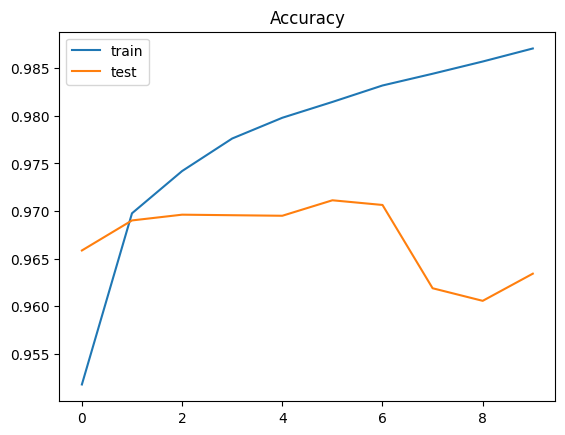

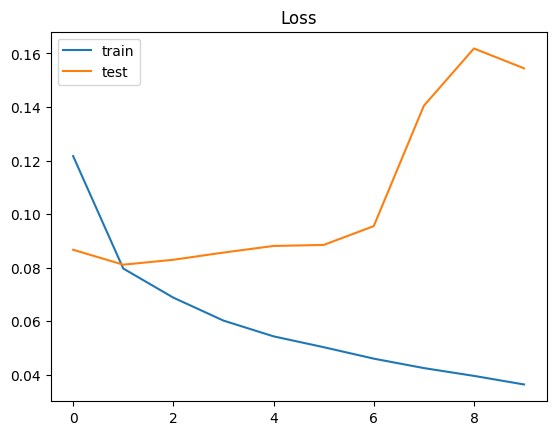

In [ ]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

Unfreezing the entire model (i.e. make the embedding layer trainable) and re-train the model could bring further improvements (similar to what is done in the [Transfer Learning](https://www.tensorflow.org/guide/keras/transfer_learning) tutorial).

Check performance on all data.

In [ ]:
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

In [ ]:
def predict_classification(params, data, model, preprocessor = None):
    """Predicts the classes

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
    model: model
        The keras model
    preprocessor: function
        Preprocessing transformations like text vectorization (if None this must be part of the model)

    Returns
    -------
    lists/arrays
        The true labels (ground truth), the predicted labels, and the prediction probabilities
    """

    import numpy as np
    from fhnw.nlp.utils.params import dataframe_to_dataset
    from fhnw.nlp.utils.params import build_preprocessed_dataset

    batch_size = 2 * params.get("batch_size", 64)
    y_column_name = params.get("y_column_name", "label")
    X_column_name = params.get("X_column_name", "text_clean")
    prediction_probability_threshold = params.get("prediction_probability_threshold", 0.5)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]

    y = data[y_column_name]

    dataset = dataframe_to_dataset(params, data, False)
    X = build_preprocessed_dataset(params, dataset, False, preprocessor)

    y_pred_prob = model.predict(X, batch_size=batch_size)
    y_pred = label_binarizer.inverse_transform(y_pred_prob, threshold=prediction_probability_threshold)

    params["labels"] = y
    params["labels_predicted"] = y_pred
    params["labels_predicted_probability"] = y_pred_prob

    return (y, y_pred, y_pred_prob)

In [ ]:
y, y_pred, y_pred_prob = predict_classification(params, data, model)

  35/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


 117/2588 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

W0000 00:00:1724508925.769754     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.771549     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.774272     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.776999     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.779669     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.782388     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.784905     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.787727     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508925.790536     200 gp

 353/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

W0000 00:00:1724508926.951784     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.953727     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.956278     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.958750     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.961552     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.964367     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.966923     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.969944     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508926.972869     192 gp

 388/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

W0000 00:00:1724508927.172048     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.173885     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.176604     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.179082     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.181697     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.184314     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.186927     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.189736     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.192544     195 gp

 438/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

W0000 00:00:1724508927.464599     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.468501     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.473097     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.478388     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.483335     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.488223     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.493495     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.498923     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.504662     195 gp

 440/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

W0000 00:00:1724508927.678171     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.682057     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.686529     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.691039     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.696320     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.701125     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.705877     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.711841     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508927.717317     200 gp

 475/2588 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

W0000 00:00:1724508927.880181     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 590/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

W0000 00:00:1724508928.518559     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.520549     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.523426     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.526327     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.529286     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.532091     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.534794     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.537775     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508928.541079     196 gp

1124/2588 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

W0000 00:00:1724508930.983752     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.985350     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.987562     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.989774     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.992158     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.994513     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.996630     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508930.999057     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.001462     196 gp

1316/2588 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

W0000 00:00:1724508931.879639     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.881576     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.884198     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.886754     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.889556     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.892304     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.894927     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.897932     196 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508931.900873     196 gp

1400/2588 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

W0000 00:00:1724508932.304602     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.306428     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.308684     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.311056     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.313558     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.316106     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.318516     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.321244     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.324016     194 gp

1484/2588 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

W0000 00:00:1724508932.736335     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.738074     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.740634     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.743116     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.745712     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.748706     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.751185     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.753925     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.756787     192 gp

1526/2588 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

W0000 00:00:1724508932.938032     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.940816     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.943595     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.946939     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.949946     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.954443     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508932.959282     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


1688/2588 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

W0000 00:00:1724508933.713229     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.714834     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.717084     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.719236     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.721509     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.723847     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.726071     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.728546     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508933.730959     201 gp

1810/2588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

W0000 00:00:1724508934.244733     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.246493     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.248706     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.251010     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.253479     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.255953     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.258383     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.261036     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.263679     192 gp

1826/2588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

W0000 00:00:1724508934.459792     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.461534     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.463759     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.466059     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.468532     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.470996     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.473384     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.476187     195 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508934.478924     195 gp

2094/2588 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

W0000 00:00:1724508935.784187     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.785964     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.788593     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.791124     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.793843     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.796481     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.799023     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.801846     200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508935.804669     200 gp

2530/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1724508937.756520     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.758271     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.760535     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.762882     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.765376     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.768228     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.770605     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.773190     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508937.775734     194 gp

2568/2588 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1724508938.023315     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.025103     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.027420     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.029753     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.032200     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.034647     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.037011     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.039705     194 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.042369     194 gp

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


W0000 00:00:1724508938.324888     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.326195     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.328027     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.330067     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.331524     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.333267     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508938.334375     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


Set Population: 331187
Accuracy: 0.9741


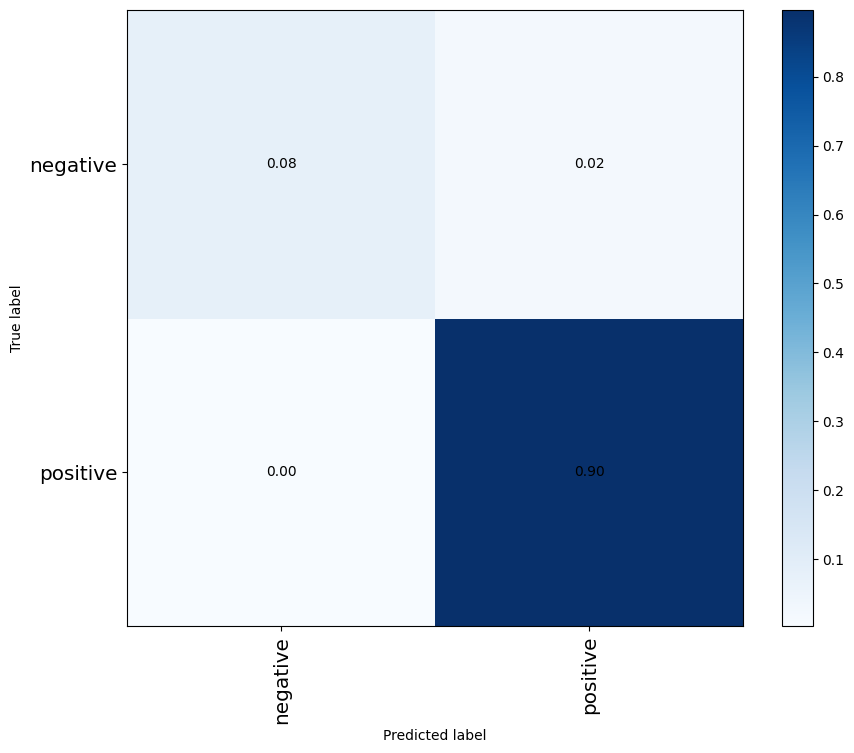

              precision    recall  f1-score   support

    negative       0.96      0.77      0.86     33022
    positive       0.98      1.00      0.99    298165

    accuracy                           0.97    331187
   macro avg       0.97      0.88      0.92    331187
weighted avg       0.97      0.97      0.97    331187

CPU times: user 5.44 s, sys: 171 ms, total: 5.61 s
Wall time: 5.41 s


In [ ]:
%%time

report_classification_results(params, data[params.get("y_column_name", "label")].tolist(), y_pred)

Check performance on test data.

In [ ]:
y_test, y_test_pred, y_test_pred_prob = predict_classification(params, data_test, model)

505/518 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1724508947.569700     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.571464     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.574063     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.576840     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.579464     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.582073     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.584554     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.587349     192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.590099     192 gp

518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


W0000 00:00:1724508947.831452     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.834155     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.838659     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.844314     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.847561     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.852095     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724508947.854351     201 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


Set Population: 66238
Accuracy: 0.9634


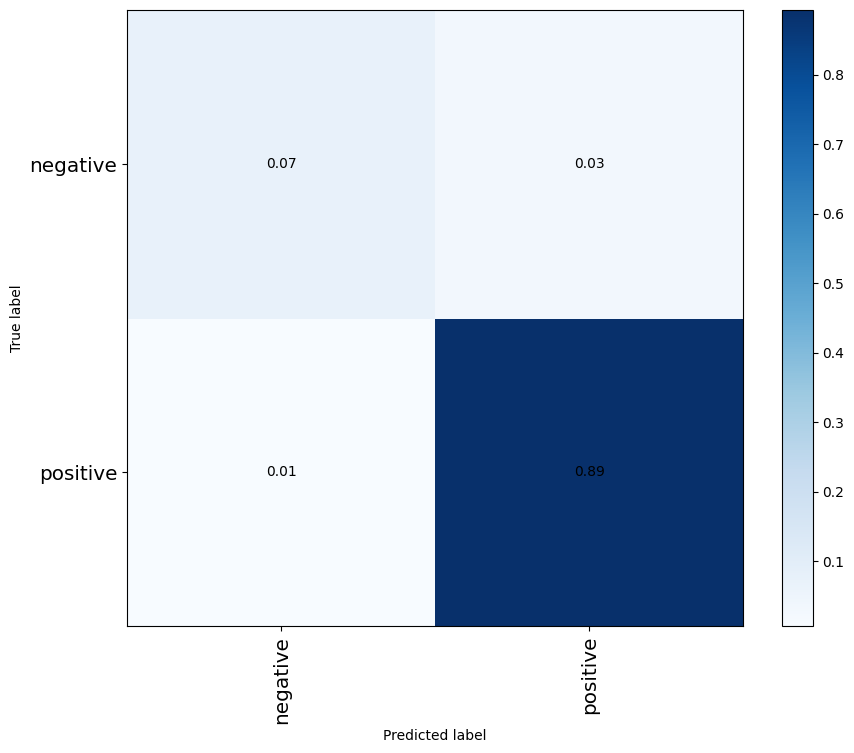

              precision    recall  f1-score   support

    negative       0.91      0.70      0.79      6604
    positive       0.97      0.99      0.98     59634

    accuracy                           0.96     66238
   macro avg       0.94      0.85      0.89     66238
weighted avg       0.96      0.96      0.96     66238

CPU times: user 982 ms, sys: 164 ms, total: 1.15 s
Wall time: 939 ms


In [ ]:
%%time

report_classification_results(params, data_test[params.get("y_column_name", "label")].tolist(), y_test_pred)

# TODO: OLD STUFF BELOW

We already removed neutral sentiments, since we classify binary.
We know we have a small dataset - let's give it a go to get experience.

In [ ]:
val_counts = data["label"].value_counts().sort_index()
val_counts

,count
label,
neg,16273
pos,6243


We use stratification for the split (keep the ratio of the classes when splitting)

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=True, random_state=43, stratify=data["label"])

X_train, y_train = data_train["text_clean"], data_train["label"]
X_test, y_test = data_test["text_clean"], data_test["label"]

# Now you have X_train, X_test, y_train, and y_test for your model training and evaluation
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16887,) (5629,) (16887,) (5629,)


We need our stopwords back

In [ ]:
# %%capture

# if ('stopwords' not in locals()):
#   !pip install 'spacy>=3.0.5'
#   !pip install nltk
#   from nltk.corpus import stopwords
#   from nltk.stem.snowball import SnowballStemmer

#   import spacy
#   !python3 -m spacy download en_core_web_md

#   nlp = spacy.load("en_core_web_md")

#   import nltk
#   nltk.download('punkt')
#   nltk.download('stopwords')

#   stemmer = SnowballStemmer("english")
#   stopwords = set(stopwords.words("english"))
#   #stopwords = set(nlp.Defaults.stop_words)
#   empty_stopwords = set()

In [ ]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# we already preprocessed
pipe = Pipeline([
         ('vec', TfidfVectorizer()),
         ("clf", SGDClassifier(n_jobs=5))
        ])

pipe.fit(X_train, y_train)

CPU times: user 242 ms, sys: 0 ns, total: 242 ms
Wall time: 212 ms


Pipeline(steps=[('vec', TfidfVectorizer()), ('clf', SGDClassifier(n_jobs=5))])

In [ ]:
%%time

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 327 ms, sys: 1.44 ms, total: 328 ms
Wall time: 428 ms


Let's get the classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

         neg       0.96      0.99      0.97     12205
         pos       0.97      0.89      0.93      4682

    accuracy                           0.96     16887
   macro avg       0.96      0.94      0.95     16887
weighted avg       0.96      0.96      0.96     16887

Test:
              precision    recall  f1-score   support

         neg       0.93      0.98      0.95      4068
         pos       0.94      0.81      0.87      1561

    accuracy                           0.93      5629
   macro avg       0.93      0.89      0.91      5629
weighted avg       0.93      0.93      0.93      5629



And the confusion matrix

Set Population: 16887
Accuracy: 0.9603


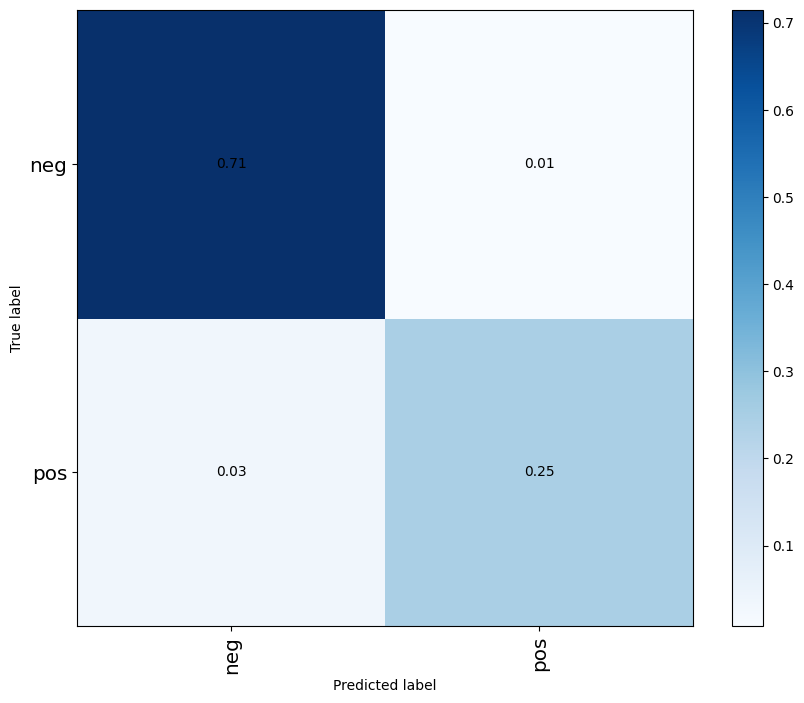

Set Population: 5629
Accuracy: 0.9311


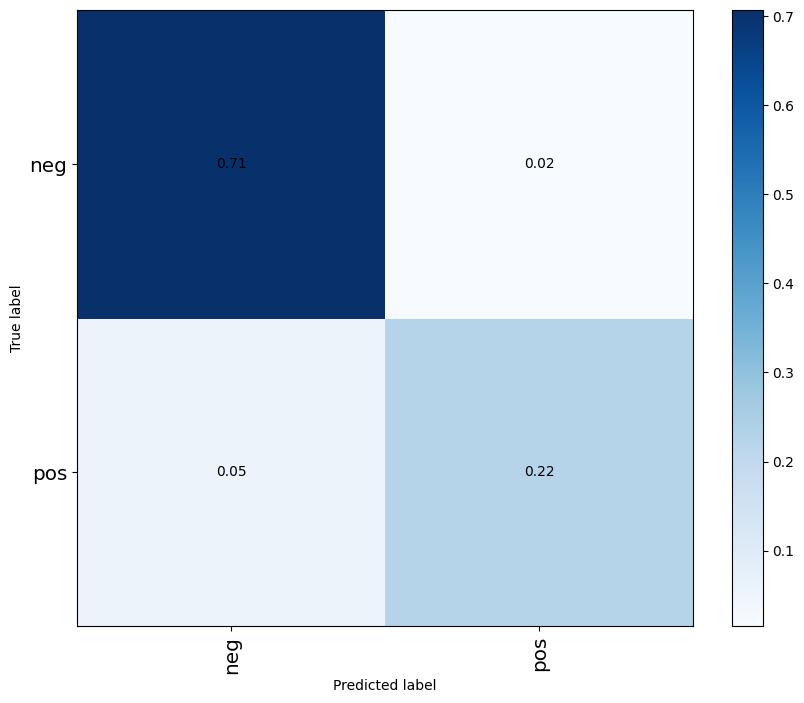

In [ ]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train.tolist(), y_train_pred)
plot_confusion_matrix(y_test.tolist(), y_test_pred)

Feature importance in order to get an idea if the class assignment builds on reasonable words

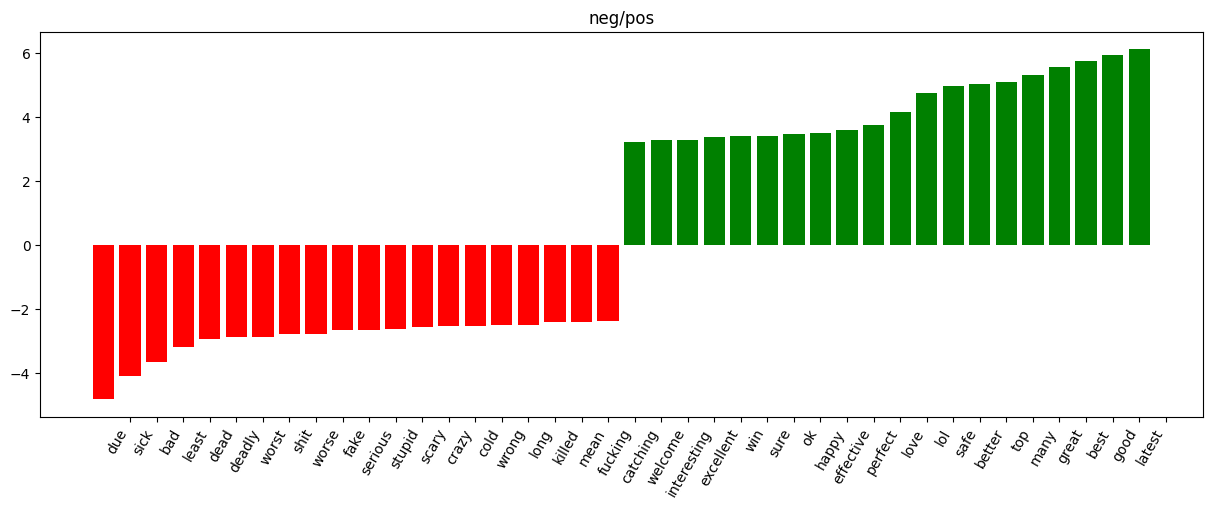

In [ ]:
from fhnw.nlp.utils.ploting import plot_feature_importance

vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names_out())

This looks good! Let's get an impression on texts with wrong prediction

In [ ]:
pd.set_option('display.max_colwidth', None)

data_train["prediction"] = y_train_pred

data_train[data_train["label"] != data_train["prediction"]][["text_clean", "label", "prediction"]]

,text_clean,label,prediction
77592,"breaking # foxnews alert : dow falls , points , suffering worst-ever one-day drop , oil prices crash coronavirus spreads",pos,neg
39263,trump knows corona virus anyone else ... ask .,pos,neg
8547,"wuhan coronavirus : , tourists lockdown cruise ship italy # health #",pos,neg
76984,"oh , thats good . # covid # coronavirus",neg,pos
21217,oh ! think corona virus ? ? ? praying ! ! ! ! im sure,neg,pos
...,...,...,...
62360,good thing coronavirus make seem less terrifying,neg,pos
22882,# viral news : misinformation coronavirus causing infodemic,pos,neg
55474,"iran temporarily release , prisoners attempt prevent spread coronavirus . mo",pos,neg
10529,always types corona virus novel virus nothing weve experienced,pos,neg


Theese seem better than the label!

# Using the Tweet Tokenized Tokens

Let's try how our tweet tokenized version fares

In [ ]:
data[data['token_clean_tweet_tokenize'].astype(str).str.contains('#')].head()

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...,"[#ccp, keep, saying, unknown, cause, pneumonia..."
31,"Brace yourself #America, this virus is nasty &...",neg,"Brace yourself #America, this virus is nasty &...",en,"[brace, #, america, ,, virus, nasty, &, killer...","[brace, yourself, #, america, ,, this, virus, ...","brace # america , virus nasty & killer . # # c...","[brace, #america, ,, virus, nasty, &, killer, ..."
49,Wtf is #coronavirus,neg,Wtf is #coronavirus,en,"[wtf, #, coronavirus]","[wtf, is, #, coronavirus]",wtf # coronavirus,"[wtf, #coronavirus]"
70,Novel #Wuhan #coronavirus virus cases leap up....,pos,Novel #Wuhan #coronavirus virus cases leap up....,en,"[novel, #, wuhan, #, coronavirus, virus, cases...","[novel, #, wuhan, #, coronavirus, virus, cases...",novel # wuhan # coronavirus virus cases leap ....,"[novel, #wuhan, #coronavirus, virus, cases, le..."
104,As #coronavirus spreads to more cities in #Chi...,pos,As #coronavirus spreads to more cities in #Chi...,en,"[#, coronavirus, spreads, cities, #, china, ,,...","[as, #, coronavirus, spreads, to, more, cities...","# coronavirus spreads cities # china , # calls...","[#coronavirus, spreads, cities, #china, ,, #wh..."


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=True, random_state=43, stratify=data["label"])

X_train, y_train = data_train["token_clean_tweet_tokenize"], data_train["label"]
X_test, y_test = data_test["token_clean_tweet_tokenize"], data_test["label"]

# Now you have X_train, X_test, y_train, and y_test for your model training and evaluation
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16887,) (5629,) (16887,) (5629,)


Let's make sure X_train contains hashtags

In [ ]:
# Display examples containing hashtags
print(X_train[X_train.astype(str).str.contains('#')].head())

77592    [breaking, #foxnews, alert, :, dow, falls, ,, ...
21346    [pathetic, response, #hkgov, towards, #wuhanvi...
71151    [email, gym, #coronavirus, maybe, least, reass...
14453    [government, requested, public, refrain, creat...
34172    [today's, show, live, amest, #demdebate, ,, lo...
Name: token_clean_tweet_tokenize, dtype: object


In [ ]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from fhnw.nlp.utils.processing import identity

# we use the tokens now
pipe = Pipeline([
         ("vec", TfidfVectorizer(tokenizer=identity, preprocessor=identity, stop_words=None)),
         ("clf", SGDClassifier(n_jobs=5))
        ])

pipe.fit(X_train, y_train)

CPU times: user 219 ms, sys: 2.87 ms, total: 222 ms
Wall time: 194 ms


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vec',
                 TfidfVectorizer(preprocessor=<function identity at 0x7a1d089239a0>,
                                 tokenizer=<function identity at 0x7a1d089239a0>)),
                ('clf', SGDClassifier(n_jobs=5))])

In [ ]:
%%time

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 158 ms, sys: 48 µs, total: 158 ms
Wall time: 156 ms


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

         neg       0.95      0.99      0.97     12205
         pos       0.97      0.87      0.92      4682

    accuracy                           0.96     16887
   macro avg       0.96      0.93      0.94     16887
weighted avg       0.96      0.96      0.96     16887

Test:
              precision    recall  f1-score   support

         neg       0.93      0.98      0.95      4068
         pos       0.94      0.80      0.86      1561

    accuracy                           0.93      5629
   macro avg       0.93      0.89      0.91      5629
weighted avg       0.93      0.93      0.93      5629



Set Population: 16887
Accuracy: 0.9560


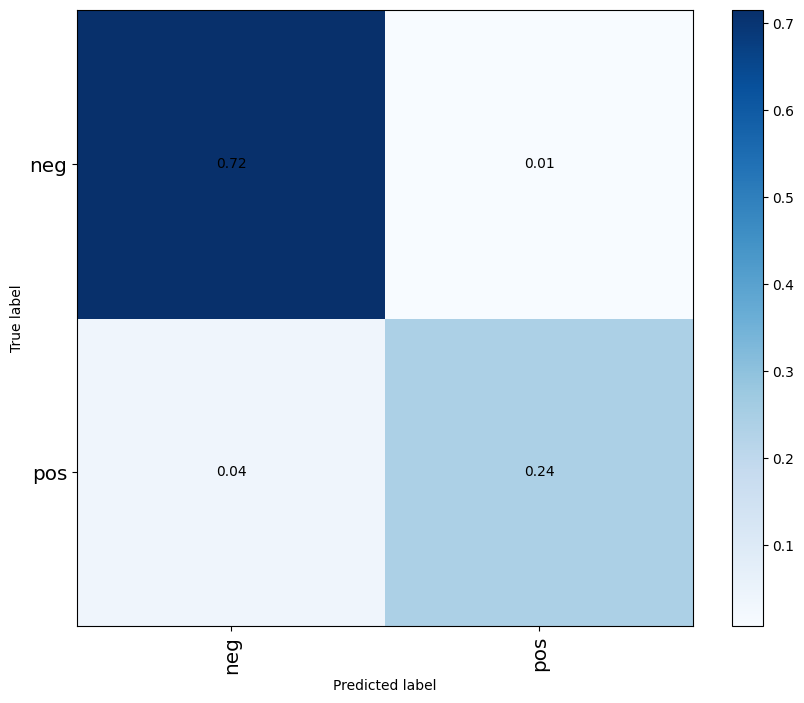

Set Population: 5629
Accuracy: 0.9297


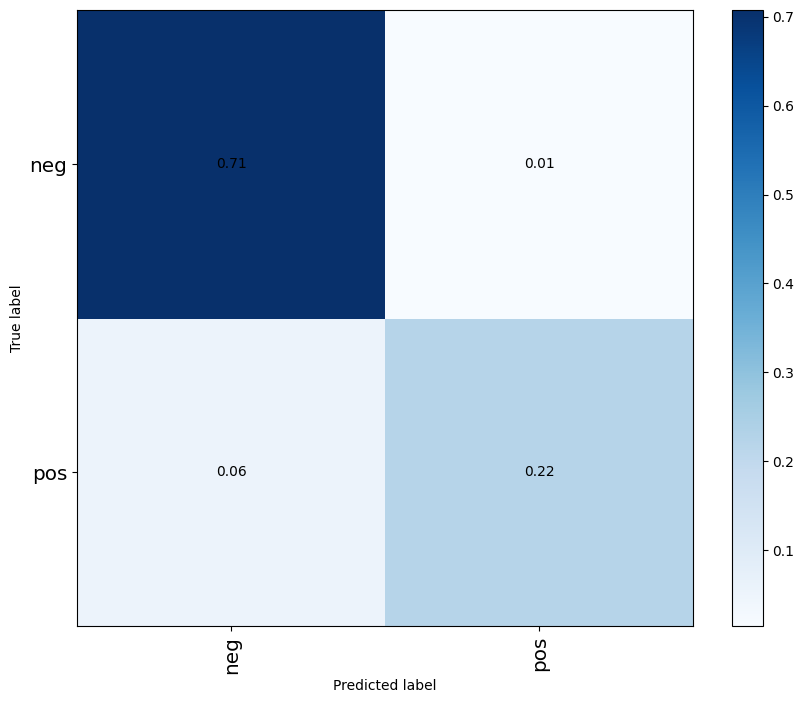

In [ ]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train.tolist(), y_train_pred)
plot_confusion_matrix(y_test.tolist(), y_test_pred)

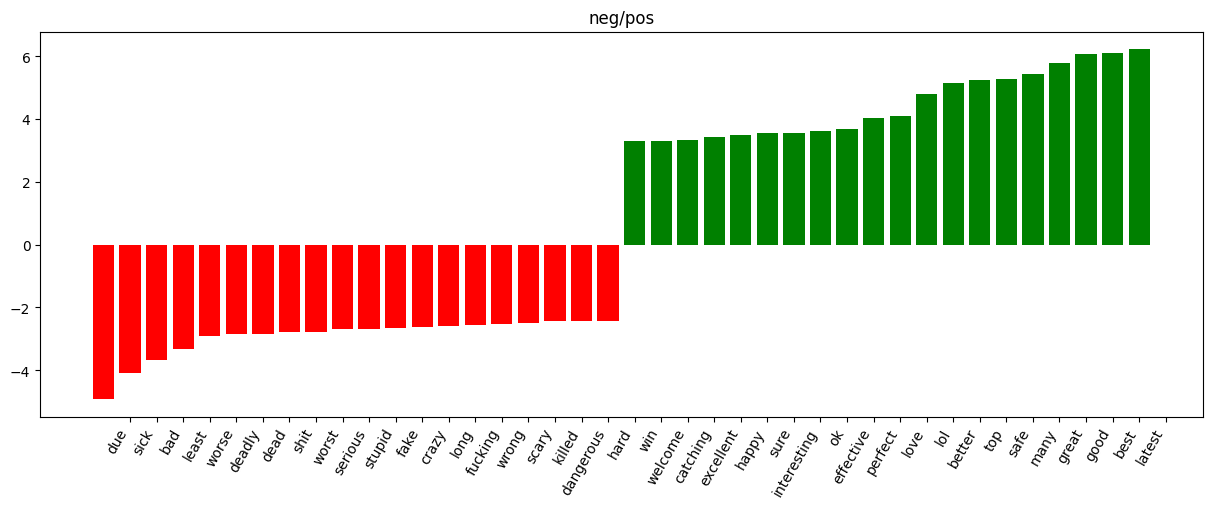

In [ ]:
from fhnw.nlp.utils.ploting import plot_feature_importance

vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names_out())

Let's see how our hashtags fare

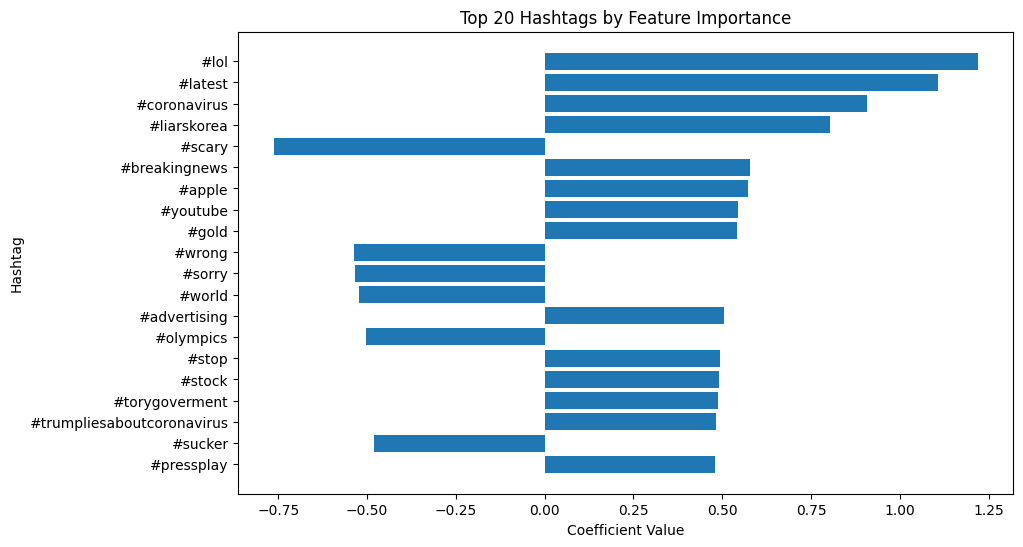

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'classifier' and 'vectorizer' are already defined as in your code.
feature_names = vectorizer.get_feature_names_out()
# Extract coefficients from the classifier
coefficients = classifier.coef_[0]

# Filter for hashtags
hashtag_indices = [i for i, name in enumerate(feature_names) if name.startswith("#")]
hashtag_names = [feature_names[i] for i in hashtag_indices]
hashtag_coefficients = [coefficients[i] for i in hashtag_indices]

# Sort hashtags by absolute coefficient magnitude
hashtag_importance = sorted(zip(hashtag_names, hashtag_coefficients), key=lambda x: abs(x[1]), reverse=True)


# Plotting the top N hashtags
N = 20 # change this value to display a different number of top features

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(range(N), [importance[1] for importance in hashtag_importance[:N]], align='center')
plt.yticks(range(N), [importance[0] for importance in hashtag_importance[:N]])
plt.xlabel('Coefficient Value')
plt.ylabel('Hashtag')
plt.title(f'Top {N} Hashtags by Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

They are not compounded enough to play a key role but they are included in the prediction

In [ ]:
pd.set_option('display.max_colwidth', None)

data_train["prediction"] = y_train_pred

data_train[data_train["label"] != data_train["prediction"]][["token_clean_tweet_tokenize", "label", "prediction"]]

,token_clean_tweet_tokenize,label,prediction
77592,"[breaking, #foxnews, alert, :, dow, falls, ,, points, ,, suffering, worst-ever, one-day, drop, ,, oil, prices, crash, coronavirus, spreads]",pos,neg
39263,"[trump, knows, corona, virus, anyone, else, ..., ask, .]",pos,neg
8547,"[wuhan, coronavirus, :, ,, tourists, lockdown, cruise, ship, italy, #health, #]",pos,neg
76984,"[oh, ,, thats, good, ., #covid, #coronavirus]",neg,pos
21217,"[oh, !, think, corona, virus, ?, ?, ?, praying, !, !, !, im, sure]",neg,pos
...,...,...,...
22882,"[#viral, news, :, misinformation, coronavirus, causing, infodemic]",pos,neg
55474,"[iran, temporarily, release, ,, prisoners, attempt, prevent, spread, coronavirus, ., mo]",pos,neg
73912,"[remarkable, thread, corruption, reporting, presidents, role, coronavirus]",pos,neg
10529,"[always, types, corona, virus, novel, virus, nothing, weve, experienced]",pos,neg


These seem also explainable

# Hyperparameter Tuning

Let's further try improving the results by using optima hypertuning.

We already tokenized during the preprocessing stage. We will compare the word tokenized tokens to the tweet optimized ones!

In [ ]:
# %%capture

# !pip uninstall optuna -y

In [ ]:
%%capture

!pip install optuna

In [ ]:
import optuna

print(optuna.__version__)

4.1.0


Can we use the same pipline?

As we have an imbalanced dataset and want to give equal importance to each class, we compare the binary to the macro average and expect better results from the latter.

In [ ]:
from sklearn.metrics import f1_score, make_scorer

scoring_function = make_scorer(f1_score, pos_label="positive", average='binary')
#scoring_function = make_scorer(f1_score, average='macro')

We define the parameters for optima:

vec__max_df: This parameter is for the TfidfVectorizer, the component that converts text into numerical features.
max_df determines the maximum document frequency for a term to be included in the vocabulary.</br>
Our setting tells Optuna to try different values for max_df between 0.5 and 0.85 (inclusive). This means words appearing in more than 85% of the documents will be ignored.

"vec__min_df": Also for the TfidfVectorizer.
min_df sets the minimum document frequency for a term.</br>
Our setting instructs Optuna to sample values between 0.0 and 0.2. This means words appearing in less than 20% of the documents will be ignored.

vec__ngram_range: (Commented out in this case, meaning it's not being tuned).
This would control whether the TfidfVectorizer considers single words (1, 1), word pairs (1, 2), or word triplets (1, 3) as features.</br>
Our setting would allow Optuna to choose from the provided options.

"vec__use_idf": For the TfidfVectorizer.
use_idf determines whether to use Inverse Document Frequency (IDF) weighting. IDF downweights words that appear frequently across all documents, making them less important for distinguishing between documents.</br>
Our setting tells Optuna to test both using IDF (True) and not using it (False).

"vec__sublinear_tf": For the TfidfVectorizer.
sublinear_tf applies a sublinear scaling to term frequencies. If True, it uses 1 + log(tf) instead of just tf to reduce the impact of very frequent terms.</br>
Our setting instructs Optuna to evaluate both options (True and False).

"vec__max_features": (Commented out)
This would limit the maximum number of features (words) to be considered by the TfidfVectorizer.</br>
Our setting would have Optuna try values between 1000 and 100,000.

"clf__alpha": This hyperparameter is for the SGDClassifier, the machine learning model used for classification.
alpha is a regularization parameter that controls the strength of the penalty imposed on the model's weights. Higher values of alpha lead to stronger regularization, which can help prevent overfitting.</br>
Our setting tells Optuna to explore values between 1e-7 and 1e-4 on a logarithmic scale.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):

    # TODO: !!! place your code here !!!
    ####################################
    #params = {
    #    "clf__alpha": trial.suggest_...,
    #    ...
    #}

    params = {
        "vec__max_df": trial.suggest_float("vec__max_df", 0.5, 0.85),
        "vec__min_df": trial.suggest_float("vec__min_df", 0.0, 0.2),
        #"vec__ngram_range": trial.suggest_categorical("vec__ngram_range", [(1, 1), (1, 2), (1, 3)]),
        "vec__use_idf": trial.suggest_categorical("vec__use_idf", [True, False]),
        "vec__sublinear_tf": trial.suggest_categorical("vec__sublinear_tf", [True, False]),
        #"vec__max_features": trial.suggest_int("vec__max_features", 1000, 100_000) ,
        "clf__alpha": trial.suggest_float("clf__alpha",1e-7, 1e-4, log=True),
    }

    ###################
    # TODO: !!! end !!!

    # set the hyper parameters to try
    pipe.set_params(**params)

    return np.mean(cross_val_score(
        pipe,
        X_train,
        y_train,
        # Stratified K-Folds cross-validator (with 3 splits/folds)
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring=scoring_function))